# Computer Vision Task 

## Problem :
In this problem we will be given images of 4 classes. The images and labels are separately converted into [pickle](https://docs.python.org/3/library/pickle.html) file. **Pickle** is used for serializing and de-serializing Python object structures, also called marshalling or flattening. Serialization refers to the process of converting an object in memory to a byte stream that can be stored on disk or sent over a network. Later on, this character stream can then be retrieved and de-serialized back to a Python object. The dataset for this problem is available [here](https://drive.google.com/drive/folders/1F2PjpJ_u_iaD-Fs0wwcymRiVVLK34-Fu). Dataset contains 3 `pickle` files (training images, labels and test images respectively) and 1 `excel` file. We will put the predictions into the excel file in format given in the in the dataset's excel file.

## Importing Necessary libraries

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
import pickle
from torch import optim
import pandas as pd

## Loading Data
Now we will load the dataset. We will use the function [`pickle.load`](https://docs.python.org/3/library/pickle.html#pickle.load) to unpickle the data. We will unpickle training images and label and check of what datatype they are. We are also doing manual one hot endcoding into integers to make it easy for loss function to decrease the loss by looking at the encoded labels. 

In [2]:
# Loading training images
Train = open('train_image.pkl','rb')
images = pickle.load(Train)
print ('Datatype of training images:',type(images))
print('No of Images:',len(images))
print('Dimension of an Image:',len(images[1]))

# Loading labels
label = open('train_label.pkl','rb')
labels = pickle.load(label)
print ('Datatype of training labels:',type(labels))
for i in range(len(labels)):
    if labels[i] == 6:
        labels[i] = 1

Datatype of training images: <class 'list'>
No of Images: 8000
Dimension of an Image: 784
Datatype of training labels: <class 'list'>


## Defining Custom Dataset Function
We will make a Dataset Function which will do all the preprocessing to the data and this will help Data_loader by giving the images and labels of the particular index as desired by the Data_loader. Following preprocessing steps are necessary
- We need to convert list into array as the data we have is in a list. So to convert it into a tensor we need to convert it into an array first, then convert it into a tensor. 
- We need to reshape the images as they are in shape 784. We will convert them into 28x28 with 1 channel.
- We need to convert the pixel values into float as we need to normalize the pixels before feeding to the network because we dont want our network to deal matrix multiplications of large numbers.

For more details on how to define your custom dataset function, go to [this guide](https://github.com/utkuozbulak/pytorch-custom-dataset-examples). It is a great guide.

In [3]:
class MyDataset(Dataset):
    
    def __init__(self, images, labels, transform = None):
        
        # Reshaping the image in format (no_of_images, height, width, channels) and converting their datatype to float 
        self.transform = transform
        self.labels = np.asarray(labels)
        self.images = np.asarray(images).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, item):
        
        # Applying transformations
        images, labels = self.images[item], self.labels[item]
        if self.transform is not None:
            images = self.transform(images)

        return images, labels

    def __len__(self):
        return len(self.labels)

### Splitting the data into Training and validation sets 

In [4]:
# Specifying the ratio in which we want to split data
validation_split = 0.2

# Setting shuffle = True to prevent training of data on same class 
shuffle_dataset = True

# Getting the indices of training and validation dataset
dataset_size = len(images)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
print('Validation data will have {} images'.format(split))

if shuffle_dataset :
    np.random.seed(42)
    np.random.shuffle(indices)

# Defining training and validation indices 
train_indices, val_indices = indices[split:], indices[:split]

# Feeding training and validation indices to SubsetRandomSampler(This will randomly generate samples)
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

Validation data will have 1600 images


### Implementing Transformations and Defining training and validation Loader
Now we will convert the data to a tensor and normalize it in range (-1,1). Then we will feed the dataset into my custom dataset function for all the preprocessing. Now we will use the function [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). It combines a dataset and a sampler, and provides single or multi-process iterators over the dataset. Then we are looking at a sample of image.

In [5]:
# Converting data to a normalized torch.FloatTensor
train_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((127.5,), (127.5,))])

# Feeding the dataset for all the preprocessing
Data = MyDataset(images, labels, transform=train_transform)

# Defining Train and validaion loader 
train_loader = torch.utils.data.DataLoader(Data, batch_size=50, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(Data, batch_size=50, sampler=valid_sampler)

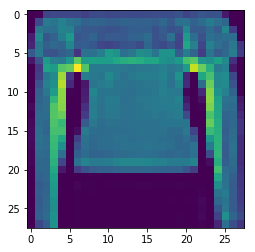

In [6]:
# Having a visualisation of dataset
photo, label = next(iter(train_loader))
plt.imshow(photo[49].squeeze())

## Defining my own Network Architecture
Here comes the main part of this project. All the cool and magical stuff happens here. We will use [Convolutional neural networks](https://medium.com/technologymadeeasy/the-best-explanation-of-convolutional-neural-networks-on-the-internet-fbb8b1ad5df8) here. CNNs, like neural networks, are made up of neurons with learnable weights and biases. Each neuron receives several inputs, takes a weighted sum over them, pass it through an activation function and responds with an output. The whole network has a loss function and all the tips and tricks that we developed for neural networks still apply on CNNs. Most common layers we will be using are :

- [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
- [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most active pixels from the previous layer.
- The usual Linear + Dropout layers to avoid overfitting and produce a 4-dim output.

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.Convolution1 = nn.Sequential(
            
            # convolutional layer
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            
            # Batch Normalization layer
            nn.BatchNorm2d(16),
            
            # Activation Function
            nn.ReLU(),
            
            # max pooling layer
            nn.MaxPool2d(kernel_size=2)
            )
        
        self.Convolution2 = nn.Sequential(
            
            # convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            
            # Batch Normalization layer
            nn.BatchNorm2d(32),
            
            # Activation Function
            nn.ReLU(),
            
            # max pooling layer
            nn.MaxPool2d(kernel_size=2))
        
        #Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)
        
        #Fully Connected 1
        self.fc = nn.Linear(32*7*7, 4)

    def forward(self, x):
        
        output = self.Convolution1(x)
        
        output = self.Convolution2(output)
        
        output = output.view(output.size(0), -1)
        
        output = self.dropout(output)
        
        output = self.fc(output)
        
        return output

# We will train model on GPU. So we need to move the model first to the GPU.
model = CNN()
if torch.cuda.is_available():
    model.cuda()
print(model)

CNN(
  (Convolution1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Convolution2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=1568, out_features=4, bias=True)
)


## Defining [Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](https://pytorch.org/docs/stable/optim.html#module-torch.optim) and Training the model
Here we will define Loss function which will calculate the loss and decide that how far we are from predicting the exact labels. Then we do backward pass to calculate the gradients. Then optimizer use these gradients to update the weights. Iterating these steps again and again, we train our model and make able to predict on unseen images or dataset.


In [8]:
# Using this torch.device we will move tensors to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Number of epochs to train the model
n_epochs = 40
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # Initiating of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Train the model 

    model.train()
    for images, labels in train_loader:
        
        # Moving tensors to GPU if CUDA is available
        images = images.to(device)
        labels = labels.to(device=device, dtype=torch.int64)
        
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # Forward pass: Pass the images to the model and compute the predictions
        output = model(images)
        
        # Calculate the batch loss
        loss = criterion(output, labels)
        
        # Backward pass: Compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Updating the parameters by performing the optimization step
        optimizer.step()
        
        # Update average training loss
        train_loss += loss.item()*images.size(0)
        
    model.eval()
    for images, labels in validation_loader:
        # Moving tensors to GPU if CUDA is available
        images = images.to(device)
        labels = labels.to(device=device, dtype=torch.int64)
     
        # Forward pass: Pass the images to the model and compute the predictions
        output = model(images)
        
        # Calculate the batch loss
        loss = criterion(output, labels)
        
        # Update validation loss 
        valid_loss += loss.item()*images.size(0)
    
    # Calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(validation_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
     # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'MY_MODEL.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.535419 	Validation Loss: 0.103237
Validation loss decreased (inf --> 0.103237).  Saving model ...
Epoch: 2 	Training Loss: 0.402783 	Validation Loss: 0.094551
Validation loss decreased (0.103237 --> 0.094551).  Saving model ...
Epoch: 3 	Training Loss: 0.368264 	Validation Loss: 0.095366
Epoch: 4 	Training Loss: 0.335808 	Validation Loss: 0.079976
Validation loss decreased (0.094551 --> 0.079976).  Saving model ...
Epoch: 5 	Training Loss: 0.313619 	Validation Loss: 0.079645
Validation loss decreased (0.079976 --> 0.079645).  Saving model ...
Epoch: 6 	Training Loss: 0.307104 	Validation Loss: 0.077837
Validation loss decreased (0.079645 --> 0.077837).  Saving model ...
Epoch: 7 	Training Loss: 0.293809 	Validation Loss: 0.077183
Validation loss decreased (0.077837 --> 0.077183).  Saving model ...
Epoch: 8 	Training Loss: 0.276550 	Validation Loss: 0.075385
Validation loss decreased (0.077183 --> 0.075385).  Saving model ...
Epoch: 9 	Training Loss: 0.276352 

In [9]:
# Loading the best model weights
model.load_state_dict(torch.load('MY_MODEL.pt'))

### Testing model

In [10]:
classes = ['0', '2', '3', '6']
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

model.eval()

# Iterate over test data
for images, labels in validation_loader:
    
    # Moving tensors to GPU if CUDA is available
    images = images.to(device)
    labels = labels.to(device=device, dtype=torch.int64)
    
    # Forward pass: Pass the images to the model and compute the predictions
    output = model(images)
    
    # Calculate the batch loss
    loss = criterion(output, labels)
    
    # Update test loss 
    test_loss += loss.item()*images.size(0)
    
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # Compare predictions to true label
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # Calculate test accuracy for each object class
    for i in range(50):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Average test loss
test_loss = test_loss/len(validation_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.068215

Test Accuracy of     0: 85% (364/425)
Test Accuracy of     2: 81% (324/399)
Test Accuracy of     3: 88% (335/379)
Test Accuracy of     6: 91% (365/397)

Test Accuracy (Overall): 86% (1388/1600)


## Transfer Learning
Transfer learning is a popular method in computer vision because it allows us to build accurate models in a timesaving way. With transfer learning, instead of starting the learning process from scratch, you start from patterns that have been learned when solving a different problem. This way you leverage previous learnings and avoid starting from scratch.

In computer vision, transfer learning is usually expressed through the use of pre-trained models. A pre-trained model is a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve. Accordingly, due to the computational cost of training such models, it is common practice to import and use models from published literature (e.g. VGG, Inception, MobileNet). Most of the pre-trained models are trained on the dataset of ImageNet.

You can read more about Transfer Learning [here](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751).

**Note** : I will be using [Resnet18](https://arxiv.org/abs/1512.03385) model. I have picked the whole code of Resnet18 model here because I was unable to implement it for 1 channel by importing and there was no implementation for 1 channel available. So I have made few modifications in the layers to get it working for me.

In [7]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=4, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


model = resnet18()

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
if train_on_gpu:
    model.cuda()
model

CUDA is available!  Training on GPU ...


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [17]:
# Using this torch.device we will move tensors to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Number of epochs to train the model
n_epochs = 40
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # Initiating of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Train the model 

    model.train()
    for images, labels in train_loader:
        
        # Moving tensors to GPU if CUDA is available
        images = images.to(device)
        labels = labels.to(device=device, dtype=torch.int64)
        
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # Forward pass: Pass the images to the model and compute the predictions
        output = model(images)
        
        # Calculate the batch loss
        loss = criterion(output, labels)
        
        # Backward pass: Compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Updating the parameters by performing the optimization step
        optimizer.step()
        
        # Update average training loss
        train_loss += loss.item()*images.size(0)
        
    model.eval()
    for images, labels in validation_loader:
        # Moving tensors to GPU if CUDA is available
        images = images.to(device)
        labels = labels.to(device=device, dtype=torch.int64)
     
        # Forward pass: Pass the images to the model and compute the predictions
        output = model(images)
        
        # Calculate the batch loss
        loss = criterion(output, labels)
        
        # Update validation loss 
        valid_loss += loss.item()*images.size(0)
    
    # Calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(validation_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
     # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'Transferlearning.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.519385 	Validation Loss: 0.100400
Validation loss decreased (inf --> 0.100400).  Saving model ...
Epoch: 2 	Training Loss: 0.358591 	Validation Loss: 0.093487
Validation loss decreased (0.100400 --> 0.093487).  Saving model ...
Epoch: 3 	Training Loss: 0.303957 	Validation Loss: 0.081480
Validation loss decreased (0.093487 --> 0.081480).  Saving model ...
Epoch: 4 	Training Loss: 0.276392 	Validation Loss: 0.097263
Epoch: 5 	Training Loss: 0.246952 	Validation Loss: 0.108985
Epoch: 6 	Training Loss: 0.233478 	Validation Loss: 0.080530
Validation loss decreased (0.081480 --> 0.080530).  Saving model ...
Epoch: 7 	Training Loss: 0.207622 	Validation Loss: 0.097386
Epoch: 8 	Training Loss: 0.195021 	Validation Loss: 0.086608
Epoch: 9 	Training Loss: 0.178416 	Validation Loss: 0.104023
Epoch: 10 	Training Loss: 0.159108 	Validation Loss: 0.118279
Epoch: 11 	Training Loss: 0.158361 	Validation Loss: 0.093051
Epoch: 12 	Training Loss: 0.128245 	Validation Loss: 0.1

In [8]:
# Loading the best model
model.load_state_dict(torch.load('Transferlearning.pt'))

## Testing Resnet18

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
classes = ['0', '2', '3', '6']
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

model.eval()

# Iterate over test data
for images, labels in validation_loader:
    
    # Moving tensors to GPU if CUDA is available
    images = images.to(device)
    labels = labels.to(device=device, dtype=torch.int64)
    
    # Forward pass: Pass the images to the model and compute the predictions
    output = model(images)
    
    # Calculate the batch loss
    loss = criterion(output, labels)
    
    # Update test loss 
    test_loss += loss.item()*images.size(0)
    
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # Compare predictions to true label
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    # Calculate test accuracy for each object class
    for i in range(50):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Average test loss
test_loss = test_loss/len(validation_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.080530

Test Accuracy of     0: 81% (346/425)
Test Accuracy of     2: 69% (276/399)
Test Accuracy of     3: 92% (349/379)
Test Accuracy of     6: 90% (360/397)

Test Accuracy (Overall): 83% (1331/1600)


## Loading Test Images

In [11]:
Test = open('test_image.pkl','rb')
testimages = pickle.load(Test)
len(testimages)

2000

### Modifying MyDataset Function
We need to remove the label preprocessing from the function as we do not have test labels.

In [12]:
class MyDataset(Dataset):
    
    def __init__(self, images, transform):
        self.transform = transform
        
        # Reshaping the image in format (no_of_images, height, width, channels) and converting their datatype to float
        self.images = np.asarray(images).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, item):
        images = self.images[item]
        
        # Applying transformation to test images
        if self.transform is not None:
            images = self.transform(images)

        return images

    def __len__(self):
        return len(self.images)

# Converting data to a normalized torch.FloatTensor
test_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((127.5,), (127.5,))])

# Feeding the test images for all the preprocessing
Data1 = MyDataset(testimages, transform=test_transform)

# Defining Test loader 
test_loader = torch.utils.data.DataLoader(Data1, batch_size=20)

### Testing
Feeding the test images through the model and saving the predictions in a list

In [13]:
def testing(model):
    # List that will store the predictions
    result = []
    # Disabling the calculation of gradients because we are testing
    with torch.no_grad():
        
        # Fetching images from testloader
        for  test in test_loader:
            
            # Importing the images to GPU
            test = test.to(device)
            
            # Feeding test images into model
            outputs = model(test)
            
            # Making the probabilities into numbers
            predicted = outputs.argmax(dim=1)
            
            # Storing the predictions in the list
            for i in range (len(test)):
                temp = int(predicted[i].cpu().numpy())
                result.append(temp)

    return result

In [17]:
result = testing(model)
# Decoding the encoded labels
for i in range(len(result)):
    if result[i] == 1:
        result[i] = 6
        
# List for the index of images
a = []
for i in range(2000):
    a.append(i+1)

In [15]:
# Inserting the predicitons to the .CSV file
pd.DataFrame({'image_index':a,'class':result}).to_csv(r'C:\Users\sharm\OneDrive\Desktop\CNN\Puneet_Sharma.csv',index=False)